In [3]:
#1. Setup and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset

# Correct raw file URL
url = "https://raw.githubusercontent.com/baheldeepti/DataBreach/main/breach_report.csv"

# Read CSV
df = pd.read_csv(url)
df.head()


,index,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description
0,0,Brooke Army Medical Center,TX,Healthcare Provider,1000.0,10/21/09,Theft,Paper/Films,No,A binder containing the protected health infor...
1,1,"Mid America Kidney Stone Association, LLC",MO,Healthcare Provider,1000.0,10/28/09,Theft,Network Server,No,Five desktop computers containing unencrypted ...
2,2,Alaska Department of Health and Social Services,AK,Healthcare Provider,501.0,10/30/09,Theft,"Other, Other Portable Electronic Device",No,\N
3,3,Health Services for Children with Special Need...,DC,Health Plan,3800.0,11/17/09,Loss,Laptop,No,A laptop was lost by an employee while in tran...
4,4,"Mark D. Lurie, MD",CA,Healthcare Provider,5166.0,11/20/09,Theft,Desktop Computer,No,A shared Computer that was used for backup was...


In [5]:
#2. Data Exploration
# Basic info
df.info()

# Summary statistics
df.describe(include='all')

# Unique breach types
print("Breach Types:", df['Type of Breach'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   index                             1654 non-null   int64  
 1   Name of Covered Entity            1654 non-null   object 
 2   State                             1645 non-null   object 
 3   Covered Entity Type               1613 non-null   object 
 4   Individuals Affected              1632 non-null   float64
 5   Breach Submission Date            1654 non-null   object 
 6   Type of Breach                    1640 non-null   object 
 7   Location of Breached Information  1643 non-null   object 
 8   Business Associate Present        1654 non-null   object 
 9   Web Description                   1257 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 129.3+ KB
Breach Types: ['Theft' 'Loss' 'Other' nan 'Hacking/IT Incident' 'Loss, Th

In [9]:
#3. Data Cleaning & Feature Engineering
# Convert date columns
df['Breach Submission Date'] = pd.to_datetime(df['Breach Submission Date'])

# Create new features
df['Breach Year'] = df['Breach Submission Date'].dt.year
df['Severity'] = pd.cut(df['Individuals Affected'], 
                        bins=[0, 1000, 10000, 100000, 1e6],
                        labels=['Low', 'Medium', 'High', 'Critical'])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df[['Type of Breach', 'Location of Breached Information']], drop_first=True)

# Combine with numerical data
df_model = pd.concat([df[['Individuals Affected']], df_encoded], axis=1)

# Simulated target label
df_model['Response Category'] = np.where(
    df['Individuals Affected'] > 100000, 'Audit + Legal',
    np.where(df['Individuals Affected'] > 10000, 'Notify + Audit', 'Notify Only')
)


C:\Users\17654\AppData\Local\Temp\ipykernel_14672\2450809276.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ts_df = df.groupby([df['Breach Submission Date'].dt.to_period('M'), 'Severity']).size().unstack().fillna(0)


<Figure size 1400x600 with 0 Axes>

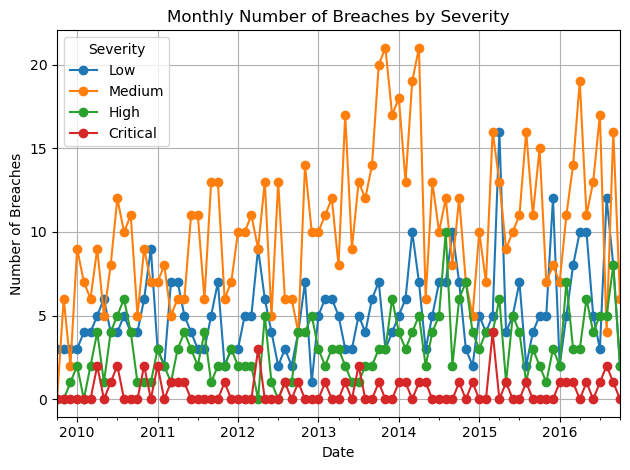

In [21]:
#exploratory analysis
#1. Time Series Chart of Breaches by Severity
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by date and severity
ts_df = df.groupby([df['Breach Submission Date'].dt.to_period('M'), 'Severity']).size().unstack().fillna(0)
ts_df.index = ts_df.index.to_timestamp()

# Plot
plt.figure(figsize=(14, 6))
ts_df.plot(marker='o')
plt.title("Monthly Number of Breaches by Severity")
plt.xlabel("Date")
plt.ylabel("Number of Breaches")
plt.grid(True)
plt.tight_layout()
plt.show()


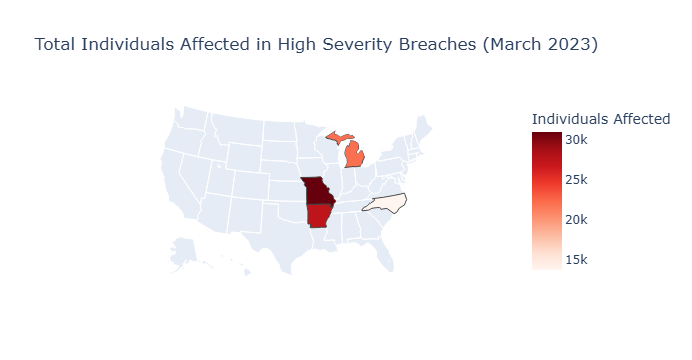

In [45]:
import plotly.express as px

# Ensure 'Individuals Affected' is numeric and drop rows with NaNs
map_df = df.copy()
map_df['Breach Month'] = map_df['Breach Submission Date'].dt.month
map_df['Individuals Affected'] = pd.to_numeric(map_df['Individuals Affected'], errors='coerce')

# Filter rows with valid state codes, selected year/month/severity, and non-null Individuals Affected
filtered_map = map_df[
    (map_df['Breach Year'] == 2016) &
    (map_df['Breach Month'] == 6) &
    (map_df['Severity'] == 'High') &
    (map_df['State'].notnull()) &
    (map_df['Individuals Affected'].notnull())
]

# Group by state and aggregate breaches
state_summary = filtered_map.groupby('State')['Individuals Affected'].sum().reset_index()

# Plot heatmap
fig = px.choropleth(
    state_summary,
    locations='State',
    locationmode='USA-states',
    color='Individuals Affected',
    scope='usa',
    color_continuous_scale='Reds',
    title='Total Individuals Affected in High Severity Breaches (March 2023)'
)

fig.show()


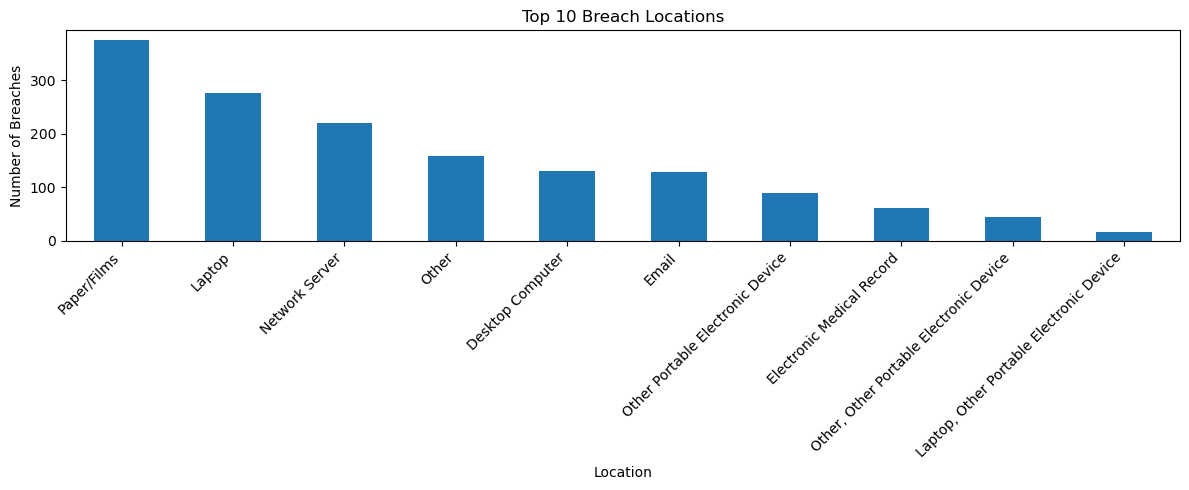

In [27]:
#✅ 3. Bar Chart: Breaches by Location of Breached Information
plt.figure(figsize=(12, 5))
df['Location of Breached Information'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Breach Locations")
plt.xlabel("Location")
plt.ylabel("Number of Breaches")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.2 kB ? eta -:--:--
   -- ------------------------------------ 20.5/301.2 kB 320.0 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/301.2 kB 544.7 kB/s eta 0:00:01
   ------------------------------------ --- 276.5/301.2 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 1.9 MB/s eta 0:00:00


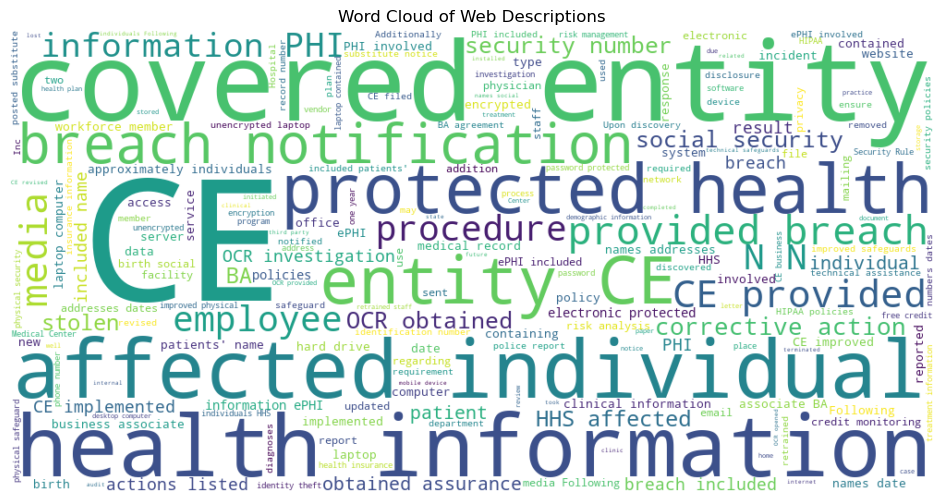

In [33]:
#✅ 4. Word Cloud and Sentiment Analysis on Web Description

from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(desc for desc in df['Web Description'].dropna())

# Word Cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Web Descriptions")
plt.show()



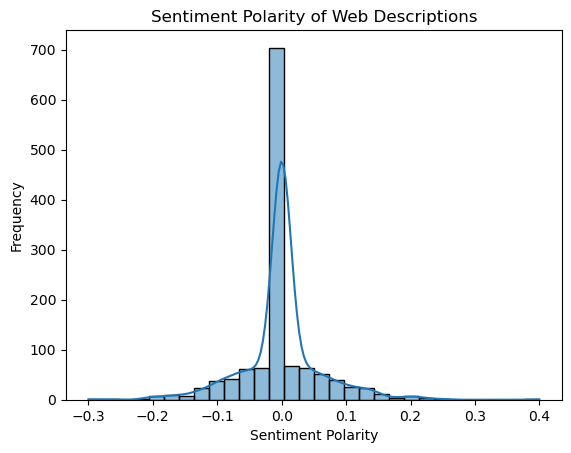

In [53]:
#Sentiment Analysis
from textblob import TextBlob
df['Sentiment Score'] = df['Web Description'].dropna().apply(lambda x: TextBlob(x).sentiment.polarity)
# Plot sentiment distribution
sns.histplot(df['Sentiment Score'].dropna(), bins=30, kde=True)
plt.title("Sentiment Polarity of Web Descriptions")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

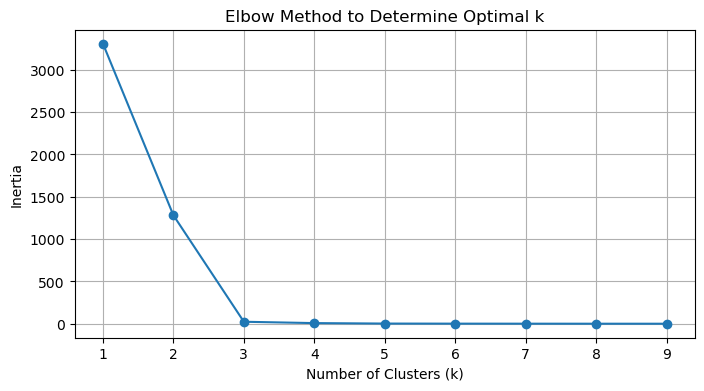

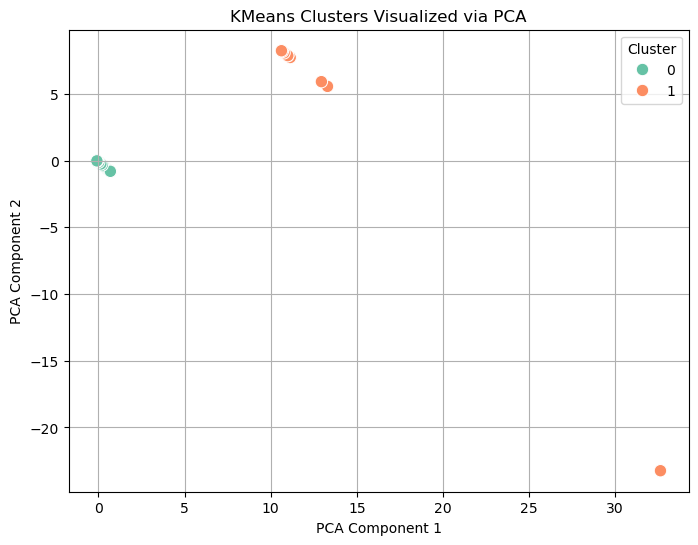

Cluster
0    1644
1      10
Name: count, dtype: int64